In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from json import load
from utils import project_points, _gaussians, generate_gaussian
from utils import heatmap2argmax, scale
from tensorflow.keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import albumentations as A
import segmentation_models as sm
import keras.backend as K

plt.rcParams["figure.figsize"] = (10, 10)

IMG_SIZE = (256, 256)
TRAIN_DIR = "dataset/"
BATCH_SIZE = 16
HEATMAPS_DIR = "heatmaps/"

Segmentation Models: using `keras` framework.


In [2]:
camera_info = load(open("./reference/camera_info.json"))

model_view_matrix = np.array(camera_info['model_view_matrix'])
projection_matrix = np.array(camera_info['projection_matrix'])

In [3]:
bounding_box_points_in_3d = np.float32(
    [(-0.156, -0.182, -0.032), 
     ( 0.156, -0.182, -0.032),
     (-0.156,  0.163, -0.032),
     ( 0.156,  0.163, -0.032),
     (-0.156, -0.182,  0.034),
     ( 0.156, -0.182,  0.034),
     (-0.156,  0.163,  0.034),
     ( 0.156,  0.163,  0.034)])

homogenious_bb_points = np.c_[bounding_box_points_in_3d, np.ones((8,1), dtype=np.float32)]

In [4]:
train = os.listdir(TRAIN_DIR)
imgs_path = []

for file in os.listdir(TRAIN_DIR):
    if file.endswith(".jpg"):
        imgs_path += [file]

mats_path = []
for file in os.listdir(TRAIN_DIR):
    if file.endswith(".json"):
        mats_path += [file]
        
mats_path.remove('camera_info.json')
mats_path = sorted(mats_path, key=lambda x: int(x.split('_')[0]))
imgs_path = sorted(imgs_path, key=lambda x: int(x.split('.')[0]))
print(len(imgs_path),len(mats_path))

100000 100000


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(imgs_path, mats_path, test_size=0.01024, random_state=42,shuffle = True)

print(len(X_train), y_train[:3],len(X_valid))

98976 ['11504_mat.json', '30849_mat.json', '59438_mat.json'] 1024


In [6]:
transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussianBlur (blur_limit=(3, 5), sigma_limit=0, always_apply=False, p=0.5)
                        ],
keypoint_params = A.KeypointParams(format='xy', remove_invisible=False))

In [7]:
def scale(p, s): return 2 * (p / s) - 1

def heatmap2argmax(heatmap):
    index = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    y = index[0]
    x = index[1]
    index = x, y
    return np.array(index)


def create_heatmaps(img_path, mat_path, is_val = False, k = False):
    """
    Applies trasform and generates a 2D Gaussian heatmaps

    mat_path - rotation matrix file name

    returns image, heatmaps, (keypoints if k = True)
    """
    heatmaps = []
    img_path, mat_path = os.path.join(TRAIN_DIR, img_path), os.path.join(TRAIN_DIR, mat_path)
    img = cv2.cvtColor(
        cv2.imread(img_path), 
        cv2.COLOR_BGR2RGB
        )
            
    rotation_matrix = np.array(load(open(mat_path)))
            
    keypoints = np.array(
        project_points(
            img, 
            homogenious_bb_points, 
            model_view_matrix, 
            projection_matrix, 
            rotation_matrix
        )
    ).astype(int)
    
    if not is_val:
        transformed = transform(image = img, keypoints = keypoints)
        img = transformed['image']
        keypoints = np.array(transformed['keypoints']).astype(int)
    
    for point in keypoints:
        p = [1,1]
        p[0] = scale(point[0], IMG_SIZE[0])
        p[1] = scale(point[1], IMG_SIZE[1])
        heatmap = generate_gaussian(np.zeros((IMG_SIZE[0], IMG_SIZE[1])), p[0], p[1])
        heatmaps.append(heatmap)
    
        
    if k:   
        return img, np.array(heatmaps), keypoints
    else:
        show
        return img, np.array(heatmaps)

In [8]:
def show(img_path, mat_path, n_maps = 8, t_visualization = False, create_keypoints = True):
    """
    Visualize heatmaps in different ways:
    if create_keypoints == True:
        img_path, mat_path - img, rotation matrix file names
        uses create_heatmaps()
    else:
        img_path, mat_path - readed data, not file names, mat_path here - array of heatmaps with shape (IMG_SIZE[0], IMG_SIZE[0], num_keypoints)
        not using create_heatmaps()
        just visualizing, without any generatings
        
    t_visualization shows whether apply trasform to an image and heatmaps and then show or not.
    Can be done only when create_keypoints == True
    """
    
    # original
    rows, columns = 1, n_maps+1
    fig = plt.figure(figsize=(40, 75))
    fig.add_subplot(rows, columns, 1)
    if create_keypoints:
        img, heatmaps, keypoints = create_heatmaps(img_path, mat_path, is_val = True, k = True)
    else:
        img, heatmaps = img_path, mat_path
        heatmaps = heatmaps.reshape(n_maps, IMG_SIZE[0], IMG_SIZE[0])
        keypoints = []
        for heatmap in heatmaps:
            keypoints.append(heatmap2argmax(heatmap))
        
    img1 = img.copy()
    for pbb in keypoints:
        keypoints_on_img = cv2.circle(img1, tuple(pbb), 2, (255,0,0), -1)
    
    plt.imshow(keypoints_on_img)
    plt.axis('off')
    plt.title("Keypoints")
    
    i = 2
    for heatmap in heatmaps:
        fig.add_subplot(rows, columns, i)
        plt.imshow(heatmap, interpolation=None)
        plt.axis('off')
        plt.title(f"Heatmap #{i-1}")
        i+=1
    
    #transformed
    if t_visualization and create_keypoints:
        fig = plt.figure(figsize=(40, 75))
        fig.add_subplot(rows, columns, 1)
        t_img, t_heatmaps, t_keypoints = create_heatmaps(img_path, mat_path, k = True)
        t_img1 = t_img.copy()
        for pbb in t_keypoints:
            keypoints_on_t_img = cv2.circle(t_img1, tuple(pbb), 2, (255,0,0), -1)
        
        plt.imshow(keypoints_on_t_img)
        plt.axis('off')
        plt.title("Transformed Keypoints")
        i = 2
        for heatmap in t_heatmaps:
            fig.add_subplot(rows, columns, i)
            plt.imshow(heatmap, interpolation=None)
            plt.axis('off')
            plt.title(f"Transformed Heatmap #{i-1}")
            i+=1

In [9]:
def train_data_gen(X, Y, BATCH_SIZE):
    start_index = 0
    
    assert len(X) == len(Y)
    
    while True:
        # Each step in this loop you yeild one batch
        
        out_imgs, out_heatmaps = [], []
        
        if start_index == 0:
             order = np.random.permutation(len(X))
        
        batch_indexes = order[start_index:start_index + BATCH_SIZE]
        
        x_batch, y_batch = np.array(X)[batch_indexes], np.array(Y)[batch_indexes]
            
        for img_path, mat_path in zip(x_batch, y_batch):
            img, heatmaps = create_heatmaps(img_path, mat_path)
            out_imgs.append(img), out_heatmaps.append(heatmaps)
        
        out_heatmaps = np.array(out_heatmaps)
            
        yield (
            np.array(out_imgs), out_heatmaps.reshape((out_heatmaps.shape[0],
                                                      out_heatmaps.shape[2],
                                                      out_heatmaps.shape[3],
                                                      out_heatmaps.shape[1]))
        )
            
        if start_index + 2*BATCH_SIZE > len(X):
            start_index = 0
        else:    
            start_index += BATCH_SIZE

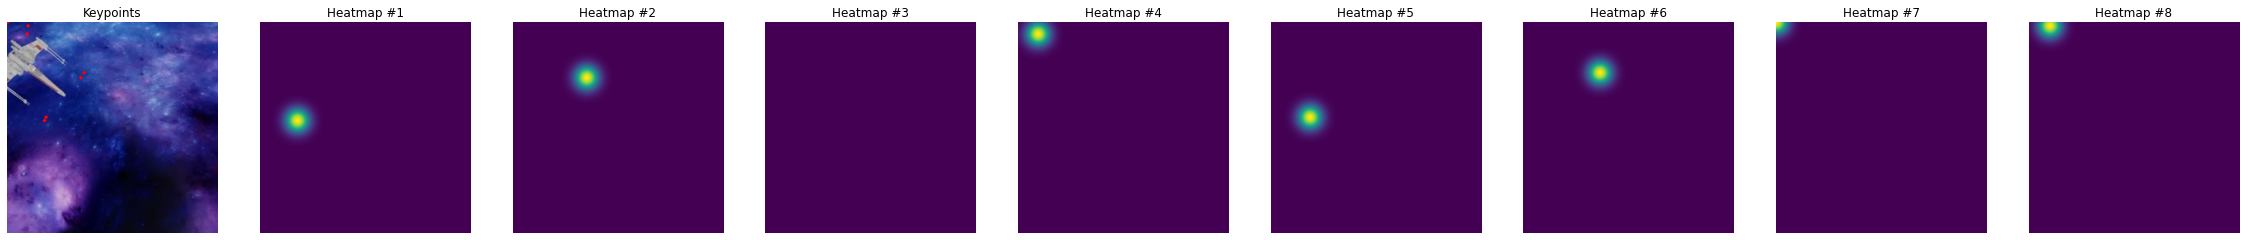

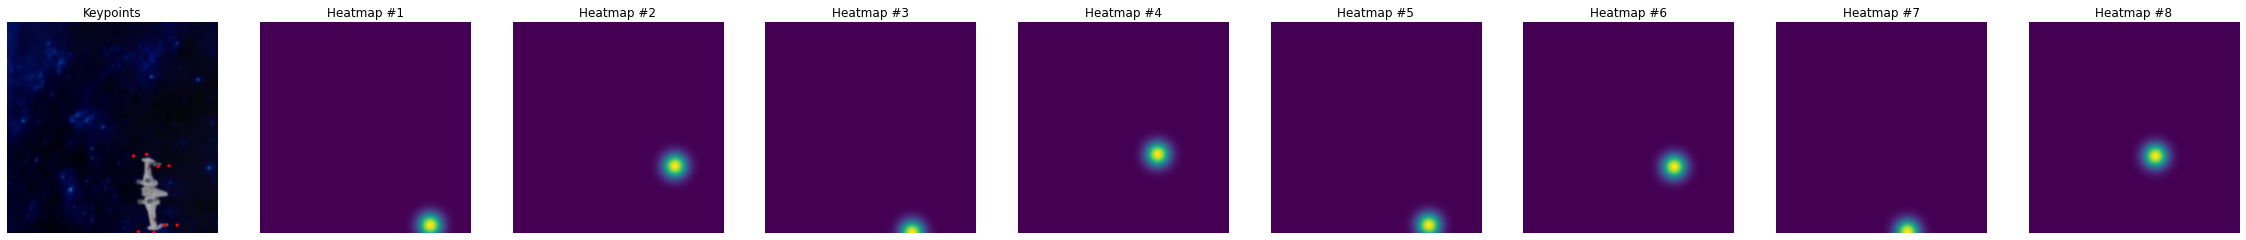

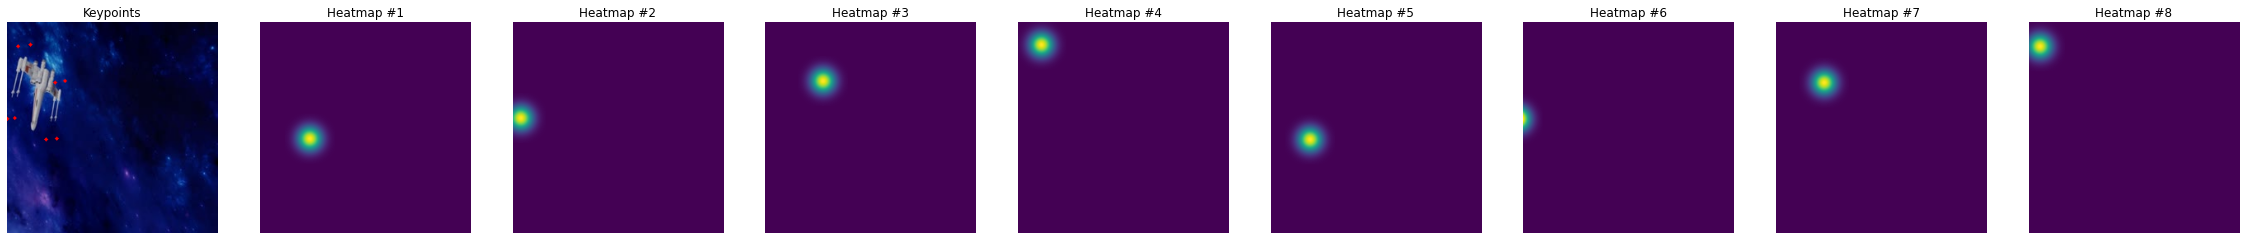

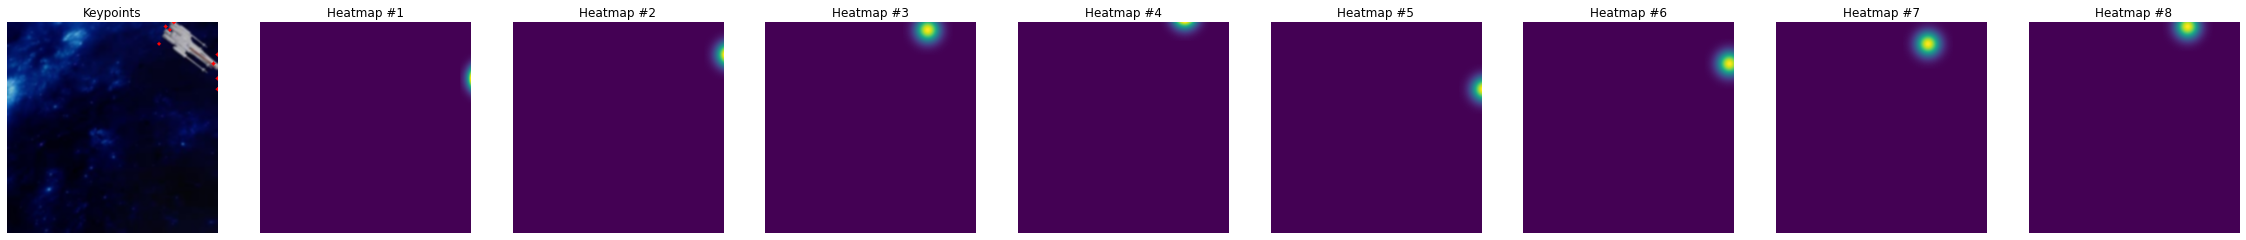

In [10]:
gen = train_data_gen(X_train[:4], y_train[:4], 4)
imgs, heatmaps = next(gen)
for img, heatmap in zip(imgs, heatmaps):
    show(img.squeeze(), heatmap.squeeze(), n_maps = 8, t_visualization = False, create_keypoints = False)

In [11]:
out_imgs, out_heatmaps = [], []
for img_path, mat_path in zip(X_valid, y_valid):
    img, heatmaps = create_heatmaps(img_path, mat_path, is_val = True)
    out_imgs.append(img), out_heatmaps.append(heatmaps)


out_imgs = np.array(out_imgs)         
out_heatmaps = np.array(out_heatmaps)
out_heatmaps = out_heatmaps.reshape((out_heatmaps.shape[0],out_heatmaps.shape[2],out_heatmaps.shape[3],out_heatmaps.shape[1]))

In [12]:
weight_path = f"result/{'NEW_unet_2Dheat'}.hdf5"

checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min', 
    save_weights_only=False
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    verbose=1, 
    mode='min',
    min_delta=0.0001, 
    cooldown=2,
    min_lr=1e-6
)

callbacks = [checkpoint, reduceLROnPlat]

In [13]:
model = sm.Unet('resnet18', classes=8, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), encoder_weights=None)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = tf.keras.losses.MeanSquaredError()
             )
model.load_weights('result/unet_2Dheat.hdf5')

In [ ]:
model.fit(
    train_data_gen(X_train, y_train, BATCH_SIZE), 
    callbacks = callbacks, 
    validation_data = (out_imgs, out_heatmaps),
    epochs = 100, 
    steps_per_epoch = len(X_train) // BATCH_SIZE - 1,
    #steps_per_epoch = 1000,
    validation_batch_size = 16
)

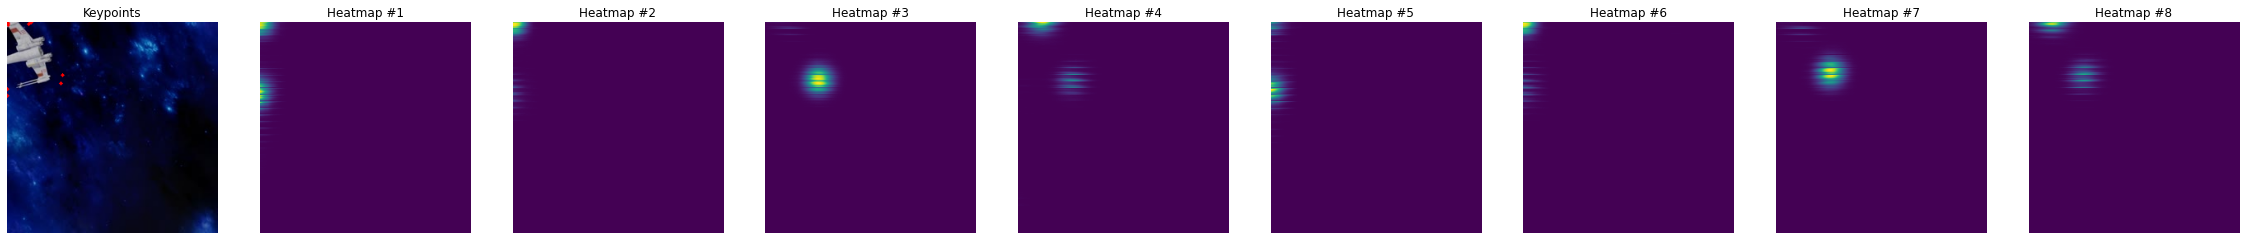

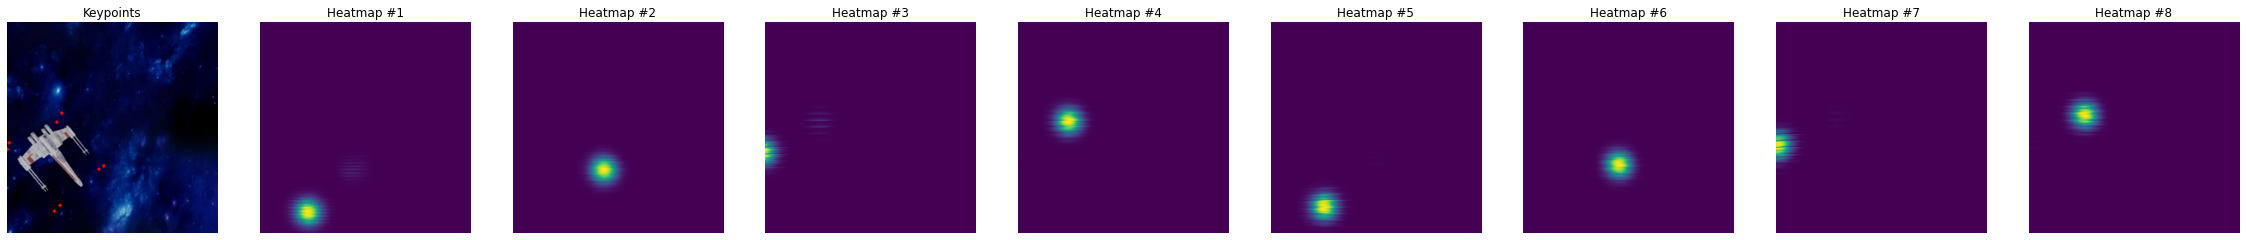

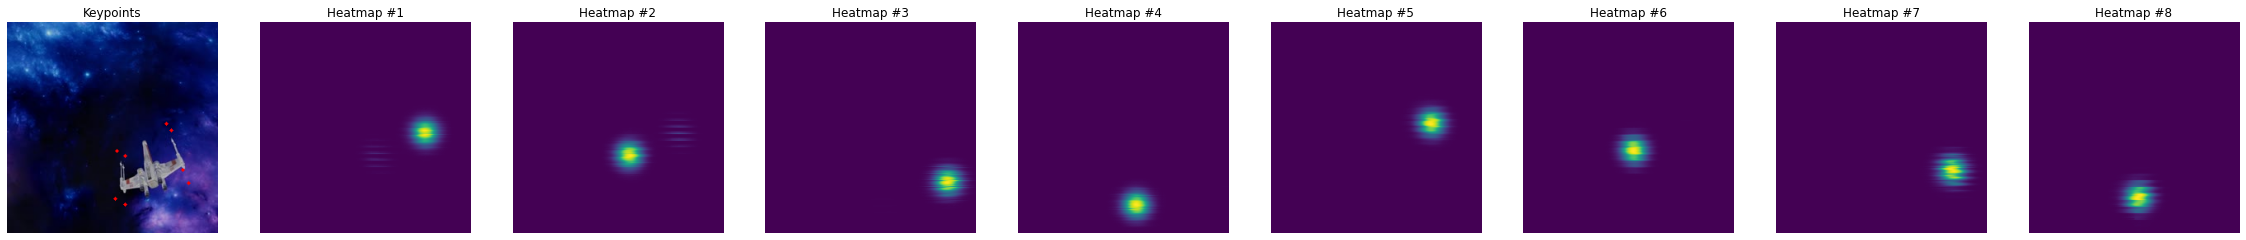

In [14]:
rows = 1
columns = 2

for img, heatmaps in zip(out_imgs[0:3], out_heatmaps[0:3]): 
    p_img = np.reshape(img, (1,256,256,3))
    pred = model.predict(p_img)
    
    show(img, pred.squeeze(), n_maps = 8, t_visualization = False, create_keypoints = False)